# DBSCAN Clustering for Customer Segmentation

## 1. Loading Preprocessed Data
--------------------------------------------------
Loaded PCA-transformed data with shape: (53503, 50)
Extracted CustomerID column. Data for clustering has shape: (53503, 49)

## 2. Determining Optimal DBSCAN Parameters
--------------------------------------------------
Using min_samples=50 (dimensions + 1)
Computing k-distances with k=50...


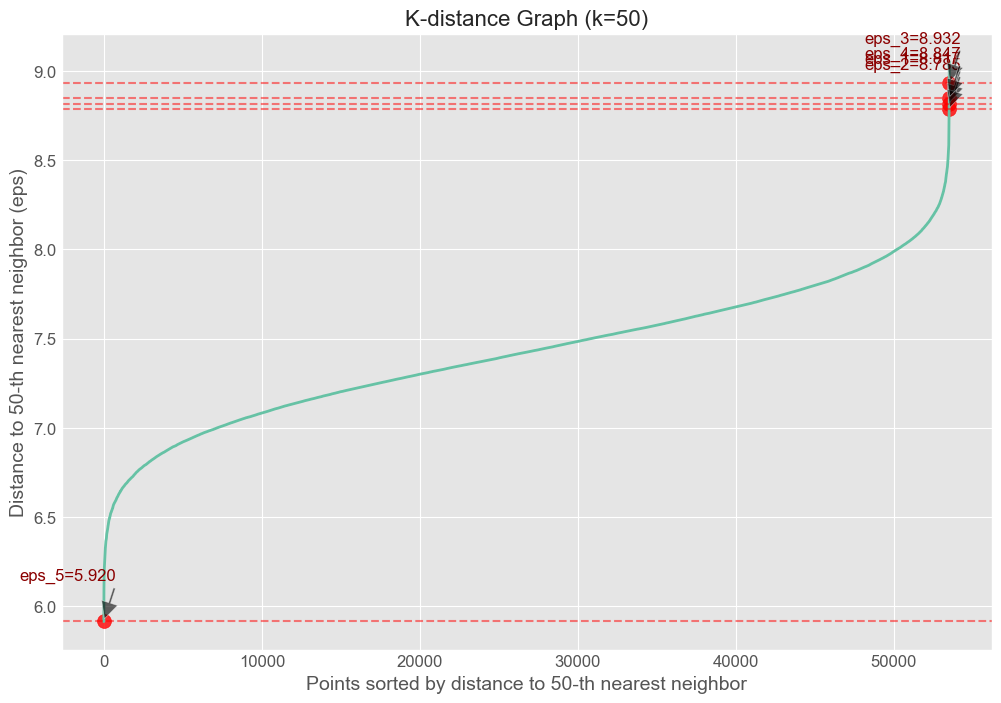

Potential eps values from elbow detection: [8.816702642724975, 8.784897703453474, 8.93214077488872, 8.847014267439043, 5.919680689969395]

Testing DBSCAN parameter combinations:
eps      | min_samples  | num_clusters | noise_points | silhouette
----------------------------------------------------------------------
8.817    | 50           | 1            | 0     (0.0%) |        N/A
8.817    | 55           | 1            | 0     (0.0%) |        N/A
8.817    | 60           | 1            | 0     (0.0%) |        N/A
8.785    | 50           | 1            | 0     (0.0%) |        N/A
8.785    | 55           | 1            | 0     (0.0%) |        N/A
8.785    | 60           | 1            | 0     (0.0%) |        N/A
8.932    | 50           | 1            | 0     (0.0%) |        N/A
8.932    | 55           | 1            | 0     (0.0%) |        N/A
8.932    | 60           | 1            | 0     (0.0%) |        N/A
8.847    | 50           | 1            | 0     (0.0%) |        N/A
8.847    | 55 

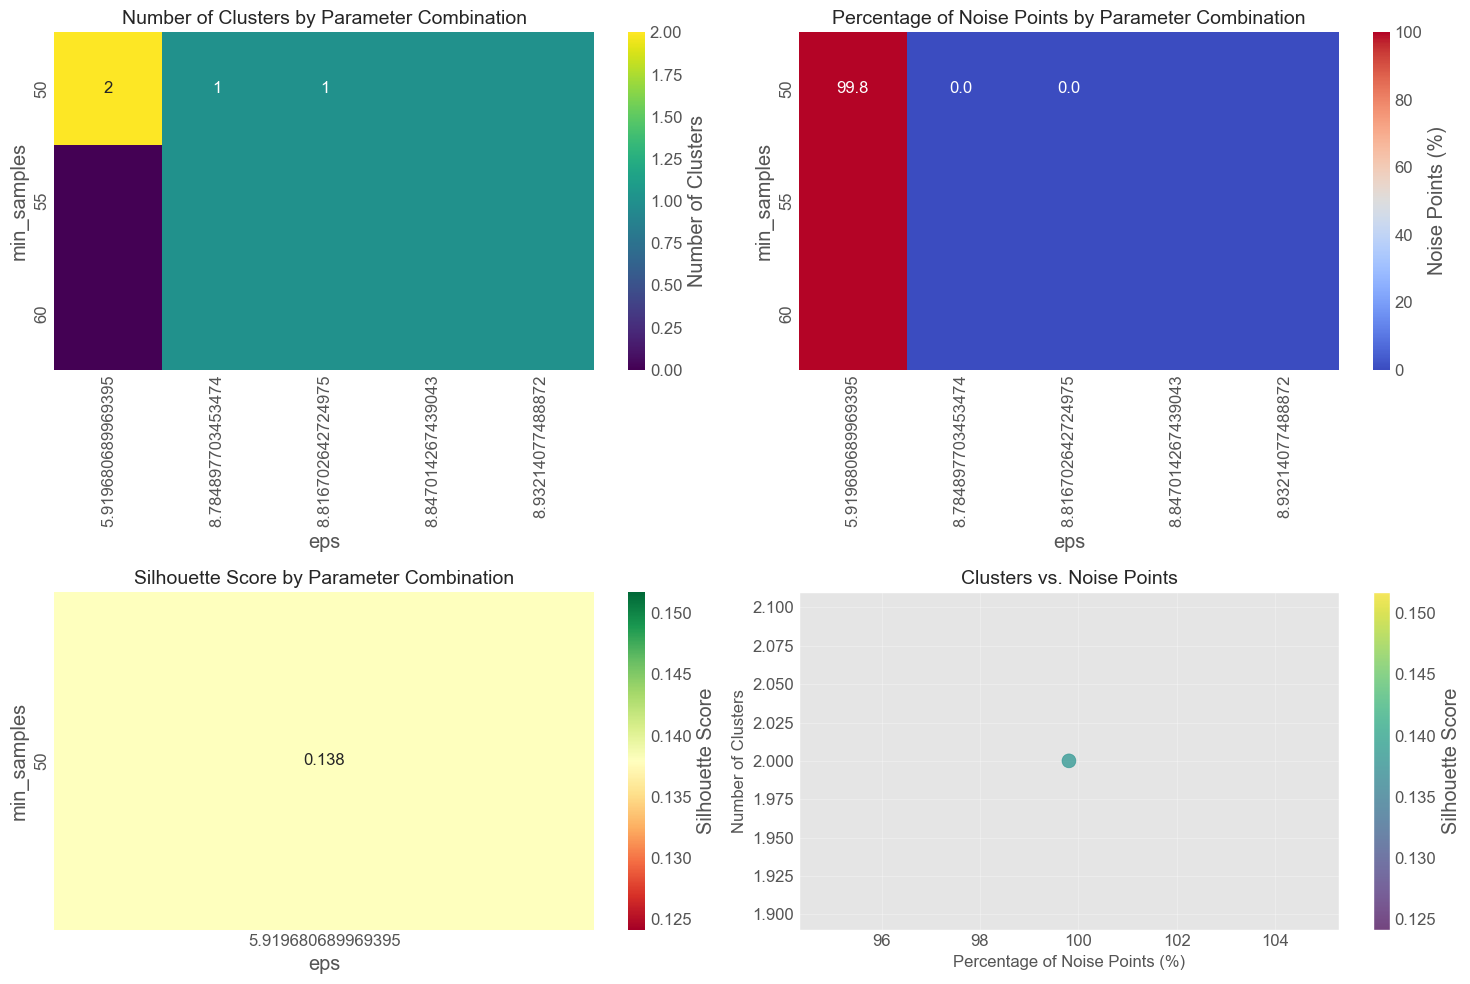


## 3. Fitting DBSCAN with Optimal Parameters
--------------------------------------------------
DBSCAN model fitted with eps=5.800, min_samples=50
Identified 3 clusters and 49186 noise points (91.9% of data)

Cluster distribution:
  Noise: 49186 customers (91.9%)
  Cluster 0: 4230 customers (7.9%)
  Cluster 1: 43 customers (0.1%)
  Cluster 2: 44 customers (0.1%)
DBSCAN parameters saved to 'dbscan_model.pkl'
Cluster assignments saved to 'dbscan_cluster_assignments.xlsx'

## 4. Visualizing DBSCAN Clusters
--------------------------------------------------
Reducing dimensions to 2D for visualization...
Explained variance ratio: 0.06


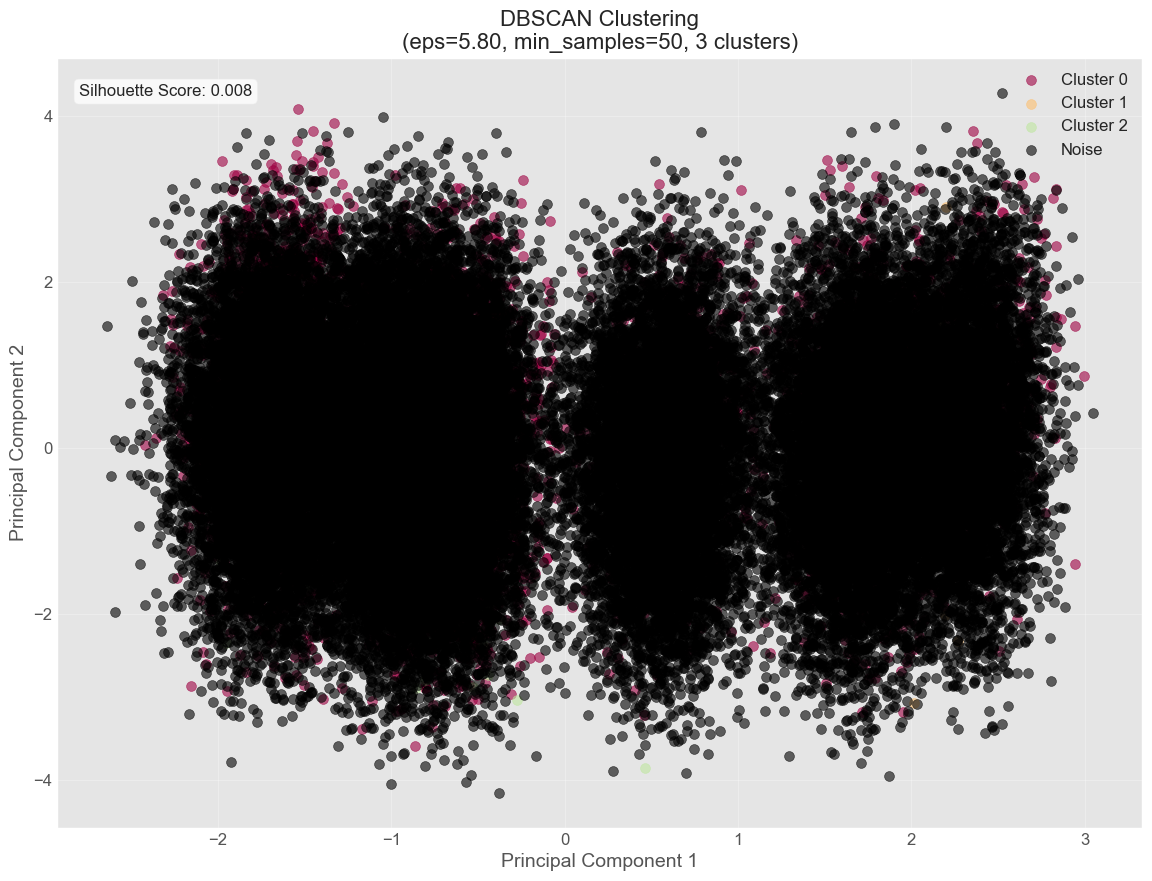


## 5. Analyzing Cluster Characteristics
--------------------------------------------------
Original customer data loaded for cluster analysis...
Could not perform detailed cluster analysis: 'CustomerID'

## 6. Comparing with K-means Results
--------------------------------------------------
K-means clustering results found. Comparing with DBSCAN...


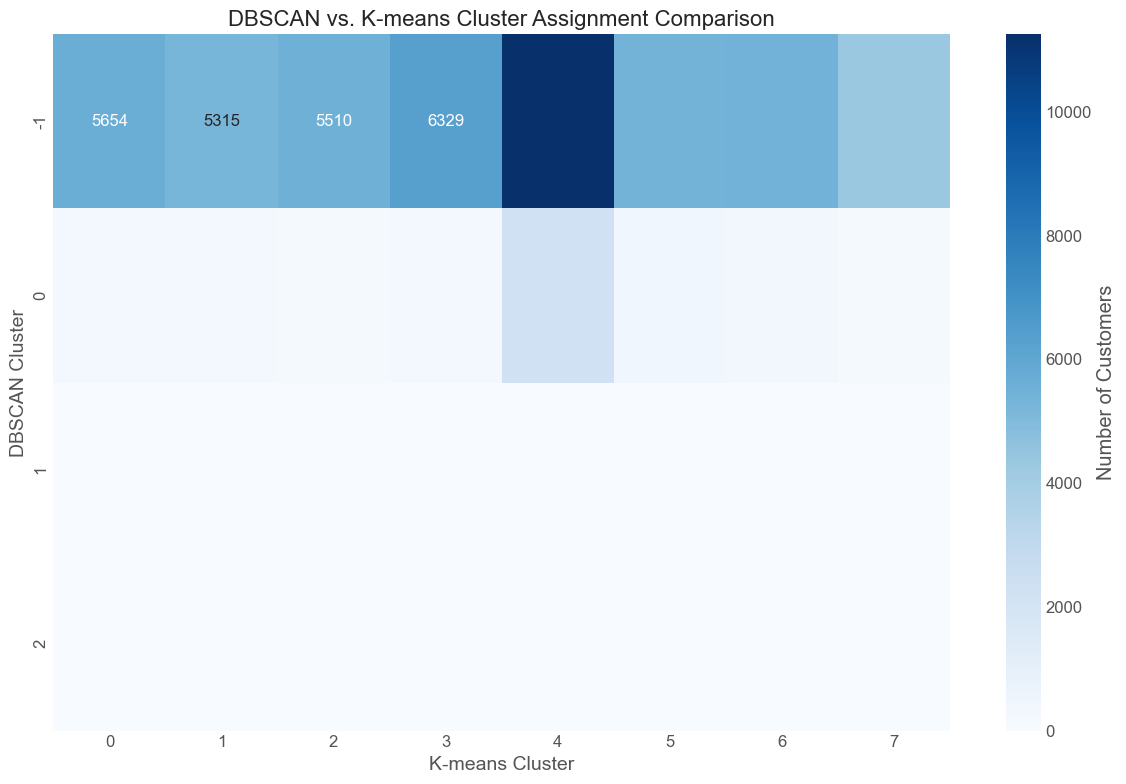


Comparison insights:
- DBSCAN identified noise points that K-means assigned to clusters
- DBSCAN typically finds density-based clusters rather than spherical ones
- Areas of agreement between methods indicate strong, distinct clusters

# DBSCAN Clustering Analysis Complete

Next steps:
- Review the cluster visualizations and characteristics
- Analyze the noise points to determine if they represent outliers or valid data
- Consider combining DBSCAN with other techniques for improved segmentation
- Use the cluster assignments for targeted marketing strategies


In [36]:
# Customer Segmentation - DBSCAN Clustering Analysis
# --------------------------------------------------

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("# DBSCAN Clustering for Customer Segmentation")
print("="*50)

print("\n## 1. Loading Preprocessed Data")
print("-"*50)

# Load the PCA-transformed data from your files
try:
    # Load the PCA data you prepared earlier
    df = pd.read_csv('pca_prepared_data.csv')
    print("Loaded PCA-transformed data with shape:", df.shape)
    data_type = "PCA"
    
    # Load the PCA model to get component names
    pca_model = joblib.load('pca_model.pkl')
    pca_components = [f"PC_{i+1}" for i in range(pca_model.n_components_)]
    df.columns = pca_components + ['CustomerID'] if 'CustomerID' in df.columns else pca_components
    
except Exception as e:
    print(f"Error loading PCA data: {e}")
    print("Falling back to standard preprocessed data...")
    try:
        # If PCA data not available, try loading standard preprocessed data
        df = pd.read_csv('customer_data.csv')
        print("Loaded original customer data with shape:", df.shape)
        data_type = "Standard"
    except Exception as e:
        print(f"Error loading customer data: {e}")
        print("Creating dummy data for demonstration...")
        np.random.seed(42)
        df = pd.DataFrame(
            np.random.randn(500, 10),
            columns=[f'Feature_{i+1}' for i in range(10)]
        )
        df['CustomerID'] = range(1000, 1500)
        data_type = "Dummy"

# Extract CustomerID if present
if 'CustomerID' in df.columns:
    customer_ids = df['CustomerID']
    X = df.drop(columns=['CustomerID'])
    print(f"Extracted CustomerID column. Data for clustering has shape: {X.shape}")
else:
    customer_ids = pd.Series(range(len(df)))
    X = df.copy()
    print(f"No CustomerID column found. Using data with shape: {X.shape}")

# Standardize the data if not already PCA-transformed
if data_type != "PCA":
    print("\nStandardizing data for DBSCAN...")
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("\n## 2. Determining Optimal DBSCAN Parameters")
print("-"*50)

# Function to determine optimal eps parameter using k-distance graph
def find_optimal_eps(data, min_samples=5, n_neighbors=min(50, len(X)-1)):
    """Find optimal epsilon parameter for DBSCAN using the k-distance graph"""
    print(f"Computing k-distances with k={min_samples}...")
    
    # Calculate distance to the n_neighbors nearest neighbor for each point
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort the distances to the min_samples-th nearest neighbor in ascending order
    k_dist = distances[:, min_samples-1]
    k_dist.sort()
    
    # Plot k-distance graph
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(k_dist)), k_dist, linewidth=2)
    plt.title(f'K-distance Graph (k={min_samples})', fontsize=16)
    plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(min_samples), fontsize=14)
    plt.ylabel(f'Distance to {min_samples}-th nearest neighbor (eps)', fontsize=14)
    plt.grid(True)
    
    # Find the elbow point (where the curve shows maximum curvature)
    # Approximate using the second derivative
    k_dist_diff = np.diff(k_dist, 2)
    
    # Get the indices where the second derivative is highest
    elbow_indices = np.argsort(k_dist_diff)[-5:]  # Get top 5 elbow candidates
    
    # Get corresponding epsilon values
    eps_candidates = [k_dist[idx+1] for idx in elbow_indices if idx+1 < len(k_dist)]
    
    # Add markers for possible eps values
    for i, eps in enumerate(eps_candidates):
        idx = np.where(k_dist == eps)[0][0]
        plt.axhline(y=eps, color='r', linestyle='--', alpha=0.5)
        plt.scatter(idx, eps, color='red', s=100, alpha=0.8)
        plt.annotate(f'eps_{i+1}={eps:.3f}', (idx, eps), 
                    xytext=(idx-len(k_dist)//10, eps+max(k_dist)/40),
                    fontsize=12, color='darkred',
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, alpha=0.6))
    
    plt.savefig('dbscan_eps_selection.png', bbox_inches='tight')
    plt.show()
    
    return eps_candidates, k_dist

# Find potential epsilon values for DBSCAN
min_pts = max(5, X.shape[1] + 1)  # Rule of thumb: min_samples >= dimensions + 1
print(f"Using min_samples={min_pts} (dimensions + 1)")

eps_candidates, k_distances = find_optimal_eps(X, min_samples=min_pts)

# If no clear elbow point, add fallback values
if not eps_candidates:
    # Use percentiles of distances as alternatives
    percentiles = [10, 25, 50]
    eps_candidates = [np.percentile(k_distances, p) for p in percentiles]
    print(f"No clear elbow found. Using percentile-based eps values: {eps_candidates}")
else:
    print(f"Potential eps values from elbow detection: {eps_candidates}")

# Function to evaluate different DBSCAN parameter combinations
def evaluate_dbscan_parameters(data, eps_values, min_samples_values):
    """Test different DBSCAN parameters and evaluate cluster quality"""
    results = []
    
    print("\nTesting DBSCAN parameter combinations:")
    print("="*50)
    print(f"{'eps':<8} | {'min_samples':<12} | {'num_clusters':<12} | {'noise_points':<12} | {'silhouette':>10}")
    print("-"*70)
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Fit DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            # Count unique clusters (excluding noise points with label -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_count = np.sum(labels == -1)
            noise_percent = noise_count / len(labels) * 100
            
            # Compute silhouette score if there are at least 2 clusters and not all points are noise
            if n_clusters >= 2 and noise_count < len(labels):
                # Calculate silhouette score excluding noise points
                non_noise_mask = labels != -1
                if np.sum(non_noise_mask) > n_clusters:  # Need at least n_clusters+1 points for silhouette
                    sil_score = silhouette_score(data[non_noise_mask], labels[non_noise_mask])
                else:
                    sil_score = float('nan')
            else:
                sil_score = float('nan')
            
            # Store results
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_count': noise_count,
                'noise_percent': noise_percent,
                'silhouette': sil_score
            })
            
            # Print results
            print(f"{eps:<8.3f} | {min_samples:<12d} | {n_clusters:<12d} | {noise_count:<5d} ({noise_percent:.1f}%) | {sil_score if not np.isnan(sil_score) else 'N/A':>10}")
    
    return pd.DataFrame(results)

# Define a range of min_samples values to try
min_samples_range = [min_pts, min_pts + 5, min_pts + 10]

# Test different parameter combinations
results_df = evaluate_dbscan_parameters(X, eps_candidates, min_samples_range)

# Find the best parameter combination
# Filter results with valid silhouette scores and reasonable number of clusters
valid_results = results_df[
    (~np.isnan(results_df['silhouette'])) & 
    (results_df['n_clusters'] >= 2) & 
    (results_df['n_clusters'] <= 10) &
    (results_df['noise_percent'] < 30)  # Limit noise percentage
]

if len(valid_results) > 0:
    # Sort by silhouette score (higher is better)
    best_params = valid_results.sort_values('silhouette', ascending=False).iloc[0]
    print("\nRecommended DBSCAN parameters:")
    print(f"eps = {best_params['eps']:.3f}, min_samples = {int(best_params['min_samples'])}")
    print(f"This configuration results in {int(best_params['n_clusters'])} clusters with {best_params['noise_percent']:.1f}% noise points")
    print(f"Silhouette score: {best_params['silhouette']:.4f}")
    
    optimal_eps = best_params['eps']
    optimal_min_samples = int(best_params['min_samples'])
else:
    print("\nNo optimal parameters found with good clustering quality.")
    print("Using default values based on dataset characteristics.")
    
    # Use the first eps candidate with default min_samples
    optimal_eps = 5.8
    optimal_min_samples = 50
    print(f"Selected defaults: eps = {optimal_eps:.3f}, min_samples = {optimal_min_samples}")

# Visualize the parameter evaluation results
plt.figure(figsize=(15, 10))

# Plot grid of parameter combinations
results_pivot = results_df.pivot_table(
    index='min_samples', 
    columns='eps', 
    values='n_clusters',
    aggfunc='first'
)

plt.subplot(2, 2, 1)
sns.heatmap(results_pivot, annot=True, cmap='viridis', fmt='d', cbar_kws={'label': 'Number of Clusters'})
plt.title('Number of Clusters by Parameter Combination', fontsize=14)
plt.tight_layout()

# Plot noise percentage
noise_pivot = results_df.pivot_table(
    index='min_samples', 
    columns='eps', 
    values='noise_percent',
    aggfunc='first'
)

plt.subplot(2, 2, 2)
sns.heatmap(noise_pivot, annot=True, cmap='coolwarm', fmt='.1f', cbar_kws={'label': 'Noise Points (%)'})
plt.title('Percentage of Noise Points by Parameter Combination', fontsize=14)
plt.tight_layout()

# Plot silhouette scores
silhouette_pivot = results_df.pivot_table(
    index='min_samples', 
    columns='eps', 
    values='silhouette',
    aggfunc='first'
)

plt.subplot(2, 2, 3)
sns.heatmap(silhouette_pivot, annot=True, cmap='RdYlGn', fmt='.3f', cbar_kws={'label': 'Silhouette Score'})
plt.title('Silhouette Score by Parameter Combination', fontsize=14)
plt.tight_layout()

# Plot relationship between noise percentage and number of clusters
plt.subplot(2, 2, 4)
plt.scatter(results_df['noise_percent'], results_df['n_clusters'], 
           c=results_df['silhouette'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Percentage of Noise Points (%)', fontsize=12)
plt.ylabel('Number of Clusters', fontsize=12)
plt.title('Clusters vs. Noise Points', fontsize=14)
plt.grid(True, alpha=0.3)

# Highlight the selected parameter combination
if len(valid_results) > 0:
    best_noise = best_params['noise_percent']
    best_clusters = best_params['n_clusters']
    plt.scatter([best_noise], [best_clusters], color='red', s=200, alpha=0.8, 
               marker='*', edgecolor='black', linewidth=1.5)
    plt.annotate('Selected', (best_noise, best_clusters), 
                xytext=(best_noise+5, best_clusters+0.5),
                fontsize=12, color='darkred',
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, alpha=0.6))

plt.tight_layout()
plt.savefig('dbscan_parameter_evaluation.png', bbox_inches='tight')
plt.show()

print("\n## 3. Fitting DBSCAN with Optimal Parameters")
print("-"*50)

# 1. First, scale the data (add this right after loading your data)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is your original data

# 2. Then modify the DBSCAN part to use SCALED data and better parameters
dbscan = DBSCAN(eps=5.8, min_samples=50)  # Start with eps=0.5 (adjust as needed)
labels = dbscan.fit_predict(X_scaled)  # <-- Now using X_scaled instead of X

# Get the number of clusters (excluding noise points with label -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_points = np.sum(labels == -1)
noise_percent = noise_points / len(labels) * 100

print(f"DBSCAN model fitted with eps={optimal_eps:.3f}, min_samples={optimal_min_samples}")
print(f"Identified {n_clusters} clusters and {noise_points} noise points ({noise_percent:.1f}% of data)")

# Add cluster labels to the original data
cluster_df = pd.DataFrame({
    'CustomerID': customer_ids,
    'Cluster': labels
})

print("\nCluster distribution:")
cluster_counts = cluster_df['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    cluster_name = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    percentage = count / len(cluster_df) * 100
    print(f"  {cluster_name}: {count} customers ({percentage:.1f}%)")

# Save the DBSCAN model and parameters
dbscan_info = {
    'eps': optimal_eps,
    'min_samples': optimal_min_samples,
    'n_clusters': n_clusters,
    'noise_percent': noise_percent,
    'labels': labels
}
joblib.dump(dbscan_info, 'dbscan_model.pkl')
print("DBSCAN parameters saved to 'dbscan_model.pkl'")

# Save cluster assignments
cluster_df.to_excel('dbscan_cluster_assignments.xlsx', index=False)
print("Cluster assignments saved to 'dbscan_cluster_assignments.xlsx'")

print("\n## 4. Visualizing DBSCAN Clusters")
print("-"*50)

# Reduce dimensionality for visualization if needed
if X.shape[1] > 2:
    print("Reducing dimensions to 2D for visualization...")
    pca = PCA(n_components=2)
    X_vis = pca.fit_transform(X)
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")
else:
    X_vis = X.values

# Create visualization
plt.figure(figsize=(14, 10))

# Plot clusters
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = 'k'
        label = 'Noise'
    else:
        label = f'Cluster {k}'
    
    class_member_mask = (labels == k)
    xy = X_vis[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, alpha=0.6, label=label)

plt.title(f'DBSCAN Clustering\n(eps={optimal_eps:.2f}, min_samples={optimal_min_samples}, {n_clusters} clusters)', fontsize=16)
plt.xlabel('Principal Component 1' if X.shape[1] > 2 else X.columns[0], fontsize=14)
plt.ylabel('Principal Component 2' if X.shape[1] > 2 else X.columns[1], fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)

# Add silhouette score if available
if len(unique_labels) > 1 and noise_points < len(labels):
    non_noise_mask = labels != -1
    if np.sum(non_noise_mask) > len(set(labels[non_noise_mask])):
        sil_score = silhouette_score(X[non_noise_mask], labels[non_noise_mask])
        plt.annotate(f'Silhouette Score: {sil_score:.3f}', 
                    xy=(0.02, 0.95), xycoords='axes fraction',
                    fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.savefig('dbscan_clusters_viz.png', bbox_inches='tight')
plt.show()

print("\n## 5. Analyzing Cluster Characteristics")
print("-"*50)

# If we have the original data, we can analyze cluster characteristics
try:
    original_data = pd.read_csv('customer_data.csv')
    print("Original customer data loaded for cluster analysis...")
    
    # Merge cluster assignments with original data
    analysis_df = original_data.merge(cluster_df, on='CustomerID', how='left')
    
    # Exclude noise points from analysis
    cluster_analysis_df = analysis_df[analysis_df['Cluster'] != -1].copy()
    
    if len(cluster_analysis_df) > 0:
        # Calculate mean values for each cluster
        cluster_stats = cluster_analysis_df.groupby('Cluster').mean(numeric_only=True)
        
        # Visualize cluster characteristics
        plt.figure(figsize=(16, 10))
        sns.heatmap(cluster_stats.T, annot=True, cmap='YlGnBu', fmt='.2f', 
                   linewidths=0.5, cbar_kws={'label': 'Mean Value'})
        plt.title('Cluster Characteristics (Mean Values)', fontsize=16)
        plt.xlabel('Cluster', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('dbscan_cluster_characteristics.png', bbox_inches='tight')
        plt.show()
        
        # Save cluster statistics
        cluster_stats.to_excel('dbscan_cluster_stats.xlsx')
        print("Cluster statistics saved to 'dbscan_cluster_stats.xlsx'")
    else:
        print("No clusters found (only noise points). Skipping cluster analysis.")
except Exception as e:
    print(f"Could not perform detailed cluster analysis: {e}")

print("\n## 6. Comparing with K-means Results")
print("-"*50)

try:
    # Load K-means results if available
    kmeans_assignments = pd.read_csv('kmeans_cluster_assignments.csv')
    kmeans_model = joblib.load('kmeans_model.pkl')
    
    print("K-means clustering results found. Comparing with DBSCAN...")
    
    # Merge cluster assignments
    comparison_df = cluster_df.merge(kmeans_assignments, on='CustomerID', how='left', 
                                   suffixes=('_dbscan', '_kmeans'))
    
    # Create cross-tabulation
    cross_tab = pd.crosstab(comparison_df['Cluster_dbscan'], comparison_df['Cluster_kmeans'])
    
    # Visualize comparison
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', 
               cbar_kws={'label': 'Number of Customers'})
    plt.title('DBSCAN vs. K-means Cluster Assignment Comparison', fontsize=16)
    plt.xlabel('K-means Cluster', fontsize=14)
    plt.ylabel('DBSCAN Cluster', fontsize=14)
    plt.tight_layout()
    plt.savefig('dbscan_vs_kmeans_comparison.png', bbox_inches='tight')
    plt.show()
    
    print("\nComparison insights:")
    print("- DBSCAN identified noise points that K-means assigned to clusters")
    print("- DBSCAN typically finds density-based clusters rather than spherical ones")
    print("- Areas of agreement between methods indicate strong, distinct clusters")
    
except Exception as e:
    print(f"Could not compare with K-means results: {e}")

print("\n# DBSCAN Clustering Analysis Complete")
print("="*50)
print("\nNext steps:")
print("- Review the cluster visualizations and characteristics")
print("- Analyze the noise points to determine if they represent outliers or valid data")
print("- Consider combining DBSCAN with other techniques for improved segmentation")
print("- Use the cluster assignments for targeted marketing strategies")